# Data Cleaning and Modeling for Florida

## import necessary libraries

In [84]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, classification_report, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

## Import data for Florida and clean

In [85]:
df = pd.read_csv('Data/covid_cases_per_county.csv')

In [4]:
FL = df[df.State == 'FL']

In [5]:
FL

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-03-21,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30
329,0,Statewide Unallocated,FL,12,0,0,0,0,0,0,...,3509,3512,3518,3523,3525,3533,3540,3545,3547,3552
330,12001,Alachua County,FL,12,0,0,0,0,0,0,...,23015,23039,23068,23098,23139,23192,23239,23273,23283,23339
331,12003,Baker County,FL,12,0,0,0,0,0,0,...,3335,3338,3340,3344,3347,3348,3350,3352,3352,3355
332,12005,Bay County,FL,12,0,0,0,0,0,0,...,19411,19411,19435,19458,19458,19458,19470,19473,19476,19476
333,12007,Bradford County,FL,12,0,0,0,0,0,0,...,2902,2907,2907,2910,2911,2912,2914,2916,2917,2919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,12125,Union County,FL,12,0,0,0,0,0,0,...,1765,1766,1770,1770,1770,1770,1771,1772,1772,1773
393,12127,Volusia County,FL,12,0,0,0,0,0,0,...,36709,36785,36887,37103,37272,37453,37623,37763,37895,38069
394,12129,Wakulla County,FL,12,0,0,0,0,0,0,...,3223,3223,3228,3232,3238,3240,3241,3241,3242,3245
395,12131,Walton County,FL,12,0,0,0,0,0,0,...,7249,7258,7262,7272,7284,7290,7293,7299,7300,7303


In [7]:
FL = FL.drop([329])

In [8]:
def CasesClean(df):
    df = df.drop(columns = ['countyFIPS','State','StateFIPS'])
    df = df.melt(id_vars=["County Name"], 
        var_name="date", 
        value_name="Cases")
    df = df.rename(columns = {'County Name':'County_Name'})
    df.date = pd.to_datetime(df.date)
    return df

In [10]:
FL = CasesClean(FL)

,County_Name,date,Cases
0,Alachua County,2020-01-22,0
1,Baker County,2020-01-22,0
2,Bay County,2020-01-22,0
3,Bradford County,2020-01-22,0
4,Brevard County,2020-01-22,0
...,...,...,...
29073,Union County,2021-03-30,1773
29074,Volusia County,2021-03-30,38069
29075,Wakulla County,2021-03-30,3245
29076,Walton County,2021-03-30,7303


In [11]:
df2 = pd.read_csv('Data/covid_county_population.csv')

In [12]:
FLpop = df2[df2.State == 'FL']


In [14]:
FLpop = FLpop.drop([330])

In [15]:
FLpop = FLpop.drop(columns = ['State', 'countyFIPS'])
FLpop = FLpop.rename(columns = {'County Name':'County_Name'})

In [20]:
df = pd.read_csv('Data/Restaurant_orders.csv')

In [21]:
## Cleaner function for restaurant data
def cleanerR(df):
    df['Effective_date'] = pd.to_datetime(df['Effective_date'])
    df.drop(columns = ['Effective_NA_Reason', 'Expiration_NA_Reason','Date_Signed','origin_dataset','Source_of_Action','URL','Citation','FIPS_State','FIPS_County','Action','Jurisdiction_Type','Issuing_Jurisdiction','order_code','Business_Type','Current_order_status','Effective_date','Expiration_date'], inplace = True)
    df.date = pd.to_datetime(df.date)
    df.sort_values(by = 'date', inplace = True)
    dfR = df[df.State_Tribe_Territory  == "FL"]
    dfR.drop(columns = ['State_Tribe_Territory'], inplace = True)
    dfR = dfR.rename(columns = {'order_group':'Rest_order'})
    return dfR

In [22]:
dfRFL = cleanerR(df)

In [39]:
## Florida has extra value = 'Authorized to fully reopen'
dfRFL.Rest_order.value_counts()

Open with limitations         9849
Authorized to fully reopen    6566
Curbside/delivery only        3015
No restriction found           134
Name: Rest_order, dtype: int64

In [23]:
df2 = pd.read_csv('Data/Mask_Mandates2.csv')

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (7,8,9,10,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



In [24]:
## Function to clean Mask Mandates data
def cleanerM(df2):
    df2.drop(columns = ['Jurisdiction_Type','Issuing_Jurisdiction','Date_Signed','origin_dataset','Source_of_Action','URL','Citation'], inplace = True)
    dfM = df2[df2.State_Tribe_Territory  == "FL"]
    dfM.drop(columns = ['FIPS_State', 'Effective_NA_Reason','Expiration_NA_Reason', 'FIPS_County','State_Tribe_Territory','Effective_date','Expiration_date'], inplace = True)
    dfM.date = pd.to_datetime(dfM.date)
    dfM = dfM.rename(columns = {'Current_order_status': 'Mask_order'})
    dfM.sort_values(by = 'date', inplace = True)
    dfM.fillna('NA', inplace = True)
    return dfM

In [25]:
dfMFL = cleanerM(df2)

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
dfMFL

,County_Name,date,Mask_order,Face_Masks_Required_in_Public
95040,Alachua County,2020-04-10,No Public Mask Mandate,NA
107811,Monroe County,2020-04-10,No Public Mask Mandate,NA
101574,Hamilton County,2020-04-10,No Public Mask Mandate,NA
108405,Okaloosa County,2020-04-10,No Public Mask Mandate,NA
103950,Jackson County,2020-04-10,No Public Mask Mandate,NA
...,...,...,...,...
105137,Lake County,2021-01-31,No Public Mask Mandate,NA
106028,Levy County,2021-01-31,No Public Mask Mandate,NA
101870,Hamilton County,2021-01-31,No Public Mask Mandate,NA
102464,Hendry County,2021-01-31,No Public Mask Mandate,NA


In [31]:
df3 = pd.read_csv('Data/Gathering_Bans.csv')

In [32]:
## Function to clean gathering bans data
def cleanerG(df3):
    df3.drop(columns = ['origin_dataset','Source_of_Action','URL','Citation','General_GB_order_code','With_SD_order_code','Outdoor_Household_Order_Code'], inplace = True)
    dfG = df3[df3.State_Tribe_Territory  == "FL"]
    dfG.drop(columns = ['FIPS_State','FIPS_County','Effective_NA_Reason','Expiration_NA_Reason','General_Household_order_code','Express_Preemption','Bans_Households_Not_Individuals_Outdoor_Only','Outdoor_Household_Order_Group','Bans_Households_Not_Individuals_Generally','outdoor_order_group','outdoor_order_code','General_Or_Under_6ft_Bans_Outdoor_Gatherings_Over','Issuing_Jurisdiction','Jurisdiction_Type','With_SD_outdoor_order_code','General_Household_Order_Group','State_Tribe_Territory','Date_Signed','Over_6ft_Bans_Outdoor_Gatherings_Over', 'Indoor_Outdoor','Effective_date','Expiration_date','Over_6ft_Bans_Gatherings_Over','General_or_Under_6ft_Bans_Gatherings_Over','With_SD_outdoor_order_group','Current_order_status'], inplace = True)
    dfG.date = pd.to_datetime(dfG.date)
    dfG.sort_values(by = 'date', inplace = True)
    dfG.fillna('NA', inplace = True)
    return dfG

In [33]:
dfGFL = cleanerG(df3)

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
## Function to merge all dataframes

def merge(df1, df2, df3, df4, df7):
    df4_copy = df4.copy()
    df7_copy = df7.copy()
    df = df1.merge(df2, how = 'outer',  on =['date','County_Name'])
    df5 = df.merge(df3, how = 'outer', on =['date','County_Name'])
 
    df4_copy.County_Name = [d[1].strip() for d in df4.County_Name.items()]
    df5.County_Name = [d[1].strip() for d in df5.County_Name.items()]
    df7.County_Name = [d[1].strip() for d in df7.County_Name.items()]
    df4_copy.County_Name = df4_copy.County_Name.astype(str)
    df5.County_Name = df5.County_Name.astype(str)
    df4_copy.sort_values(by='County_Name',inplace=True)
    df6 = df5.merge(df4_copy, on=['County_Name','date'], how="outer")
    df8 = df6.merge(df7, on=['County_Name'], how="left")
    df8.sort_values(by='County_Name', inplace=True)
   
    start_date = '2020-03-11'
    end_date = '2021-01-31'
    after_start_date = df8["date"] >= start_date

    before_end_date = df8["date"] <= end_date

    between_two_dates = after_start_date & before_end_date

    final = df8.loc[between_two_dates]
    
    final.sort_values(by = ['date','County_Name'], inplace = True)
    final['Cases/Population'] = final.apply(lambda row: row.Cases/row.population, axis = 1)
    final['Cases/Population'].fillna(0, inplace = True)
    final.fillna('NA', inplace = True)
    R = {'NA':0,'No restriction found':1,'Curbside/delivery only':2,'Open with limitations':3, 'Authorized to fully reopen':4}
    final.Rest_order.replace(R, inplace=True)
    M = {'NA':0,'No Public Mask Mandate' :1,'Public Mask Mandate':2}
    final.Mask_order.replace(M, inplace=True)
    F = {'NA':0,'Yes' :1}
    final.Face_Masks_Required_in_Public.replace(F, inplace=True)
    S = {'NA':0,'Ban of gatherings over 51-100 people' :1,'No order found':2}
    final.With_SD_order_group.replace(S, inplace=True)
    G = {'NA':0,'No order found':1,'Ban of gatherings over 11-25 people':2,'Ban of gatherings over 1-10 people':3,'Bans gatherings of any size':4}
    final.General_GB_order_group.replace(G, inplace=True)
    return final

finaldfFL = merge(dfRFL, dfMFL, dfGFL, FL, FLpop)
finaldfFL


C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,County_Name,date,Rest_order,Mask_order,Face_Masks_Required_in_Public,General_GB_order_group,With_SD_order_group,Cases,population,Cases/Population
21641,Alachua County,2020-03-11,0,0,0,1,2,1,269043,0.000004
21705,Baker County,2020-03-11,0,0,0,1,2,0,29210,0.000000
21649,Bay County,2020-03-11,0,0,0,1,2,0,174705,0.000000
21685,Bradford County,2020-03-11,0,0,0,1,2,0,28201,0.000000
21665,Brevard County,2020-03-11,0,0,0,1,2,0,601942,0.000000
...,...,...,...,...,...,...,...,...,...,...
21627,Union County,2021-01-31,0,1,0,0,0,1664,15237,0.109208
21616,Volusia County,2021-01-31,0,1,0,0,0,30961,553284,0.055959
21583,Wakulla County,2021-01-31,0,1,0,0,0,2960,33739,0.087732
21594,Walton County,2021-01-31,0,1,0,0,0,6294,74071,0.084973


In [49]:
finaldfFL.to_csv('Data/Florida_data.csv', index = False)

## Modeling

In [41]:
y = finaldfFL['Cases/Population']
X = finaldfFL.drop(columns = ['Cases/Population', 'County_Name','date','population','Cases'], axis = 1)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [43]:
## Model Evaluator Function
def evaluator(X_train, y_train, X_test, y_test, model):   
    start = time.time()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    end = time.time()
    print("Model Time: {}".format(end-start))
    print('R Squared Score is:', r2_score(y_test, test_preds))
    print('Training:')
    print('Mean Absolute Error:', mean_absolute_error(y_train, train_preds))  
    print('Mean Squared Error:', mean_squared_error(y_train, train_preds))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, train_preds)))
    print('Testing:')
    print('Mean Absolute Error:', mean_absolute_error(y_test, test_preds))  
    print('Mean Squared Error:', mean_squared_error(y_test, test_preds))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_preds)))

In [50]:
GBR=GradientBoostingRegressor()


search_grid={'n_estimators':[100,200,500],'learning_rate':[.25,.4,.5],'max_depth':[4,7,10],'subsample':[.1,.25,.5],'random_state':[2,3]}

GBR_grid=GridSearchCV(estimator=GBR,param_grid=search_grid, scoring = 'neg_mean_squared_error')

evaluator(x_train, y_train, x_test, y_test, GBR_grid)

Model Time: 265.3503625392914
R Squared Score is: 0.6336005838749678
Training:
Mean Absolute Error: 0.011234132871618884
Mean Squared Error: 0.0003118080605059521
Root Mean Squared Error: 0.017658087679756043
Testing:
Mean Absolute Error: 0.011297040577091784
Mean Squared Error: 0.0003035919001125868
Root Mean Squared Error: 0.017423888776980492


In [51]:
GBR_grid.best_params_

{'learning_rate': 0.4,
 'max_depth': 7,
 'n_estimators': 500,
 'random_state': 2,
 'subsample': 0.25}

In [52]:
GBR_best = GradientBoostingRegressor(learning_rate = 0.4,
 max_depth = 7,
 n_estimators = 500,
 random_state= 2,
 subsample= 0.25)

evaluator(x_train, y_train, x_test, y_test, GBR_best)

Model Time: 0.8934111595153809
R Squared Score is: 0.6336005838749678
Training:
Mean Absolute Error: 0.011234132871618884
Mean Squared Error: 0.0003118080605059521
Root Mean Squared Error: 0.017658087679756043
Testing:
Mean Absolute Error: 0.011297040577091784
Mean Squared Error: 0.0003035919001125868
Root Mean Squared Error: 0.017423888776980492


In [53]:
## Function to view feature importance
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), x_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

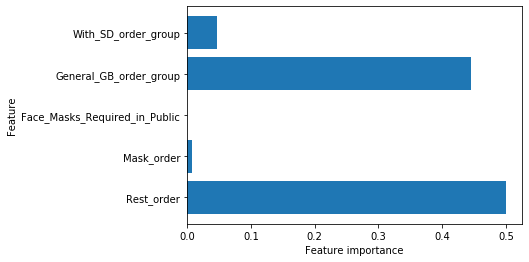

In [54]:
plot_feature_importances(GBR_best)

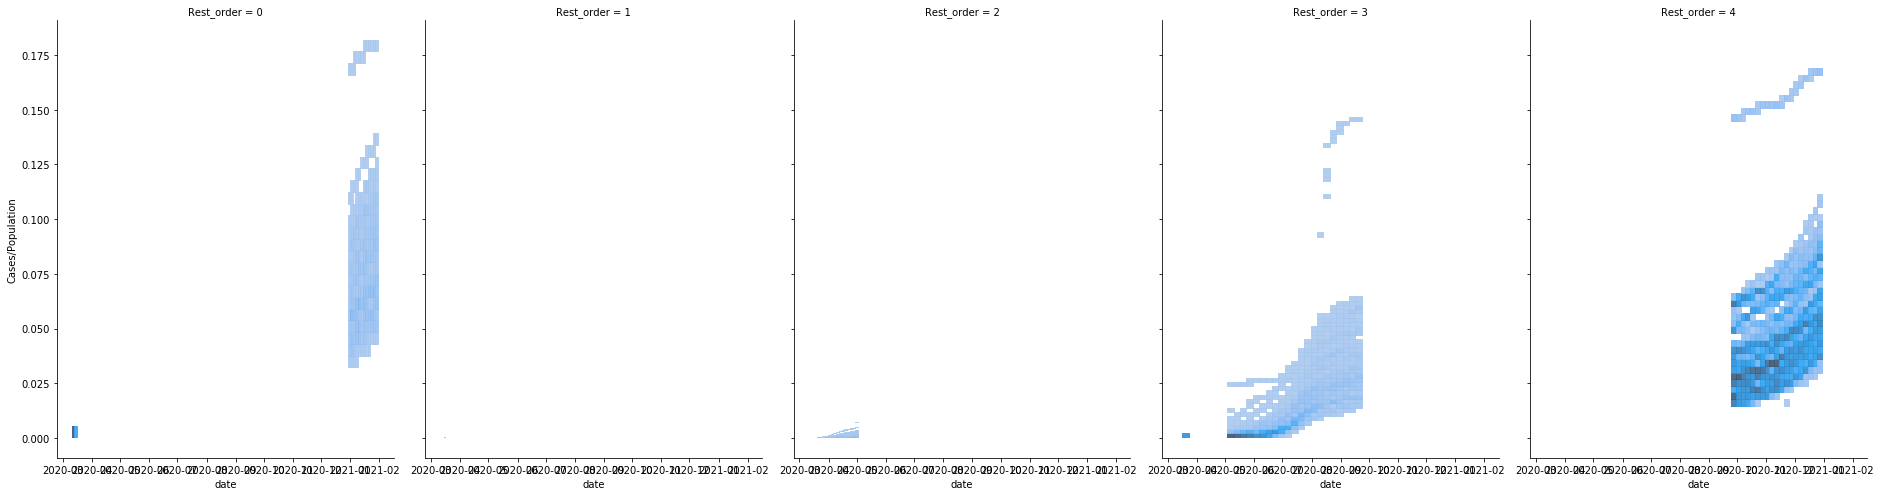

In [71]:

g = sns.FacetGrid(finaldfFL, col="Rest_order", height = 7, aspect = .75)
g.map(sns.histplot, "date", "Cases/Population", alpha=.9)
g.add_legend()

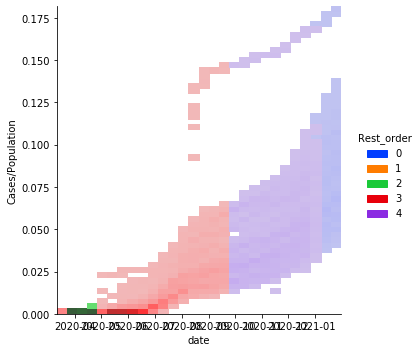

In [78]:
sns.color_palette("bright")
sns.displot(data = finaldfFL, x = "date", y = "Cases/Population", hue = "Rest_order", palette = "bright")

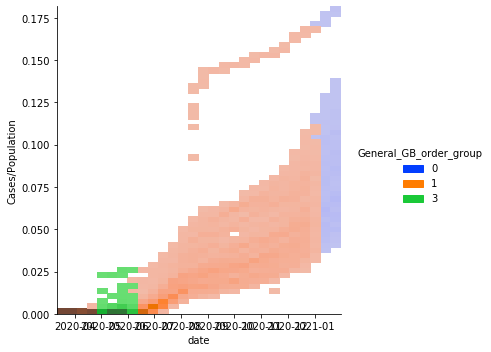

In [79]:
sns.displot(data = finaldfFL, x = "date", y = "Cases/Population", hue = "General_GB_order_group", palette = "bright")

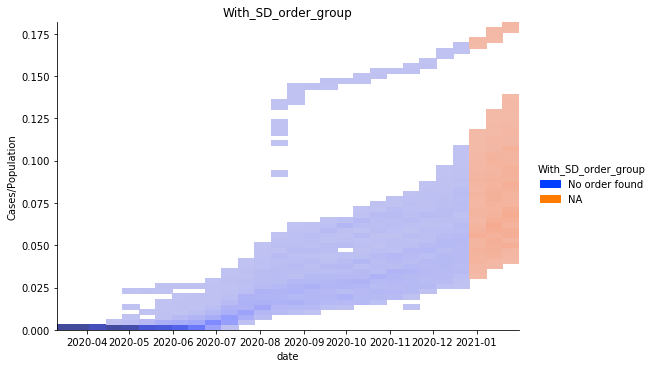

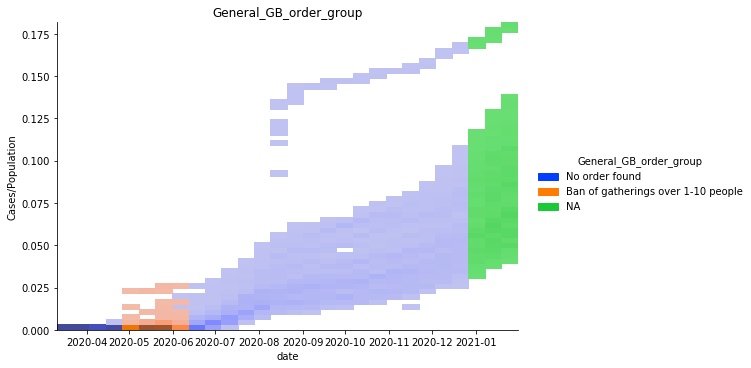

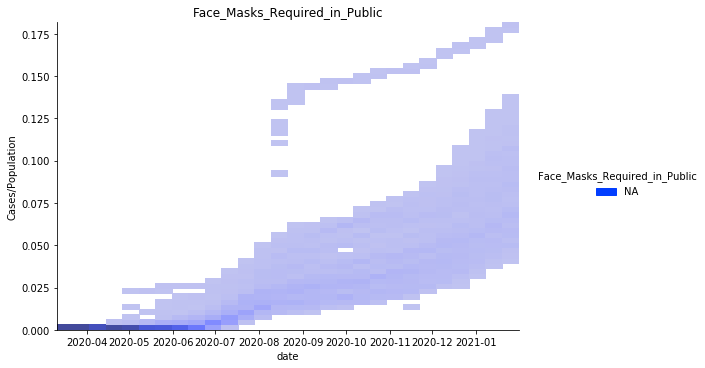

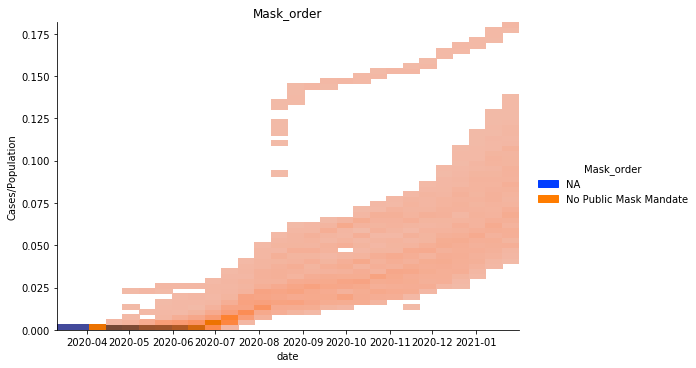

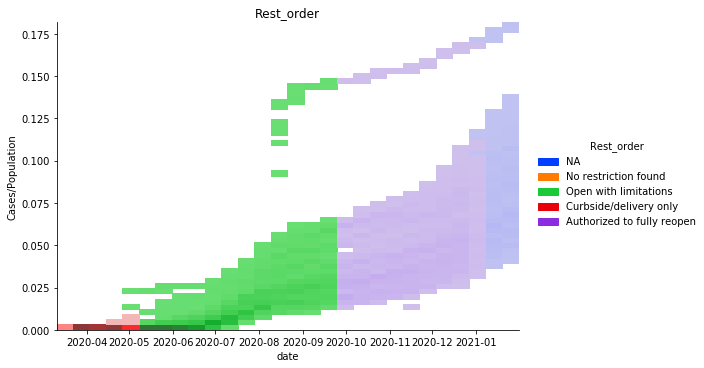

In [82]:
S = {0:'NA',1:'Ban of gatherings over 51-100 people',2:'No order found'}
finaldfFL.With_SD_order_group.replace(S, inplace=True)
G = {0:'NA',1:'No order found',2:'Ban of gatherings over 11-25 people',3:'Ban of gatherings over 1-10 people',4:'Bans gatherings of any size'}
finaldfFL.General_GB_order_group.replace(G, inplace=True)
M = {0:'NA',1:'No Public Mask Mandate',2:'Public Mask Mandate'}
finaldfFL.Mask_order.replace(M, inplace=True)
F = {0:'NA',1:'Yes'}
finaldfFL.Face_Masks_Required_in_Public.replace(F, inplace=True)
R = {0:'NA',1:'No restriction found',2:'Curbside/delivery only',3:'Open with limitations',4:'Authorized to fully reopen'}
finaldfFL.Rest_order.replace(R, inplace=True)



hues = ["With_SD_order_group","General_GB_order_group","Face_Masks_Required_in_Public","Mask_order","Rest_order"]


for hue in hues:
    sns.displot(data = finaldfFL, x = "date", y = "Cases/Population", hue = hue, palette = "bright", aspect = 1.5)
    plt.title(f"{hue}")